# Understanding how the directed FGOC score predicts membership in operons
The scripts are aimed at justifying the use of FGOC or dirFGOC scores. The main point is that the higher the score , higher is the chance that the gene pairs are within operons. <br />
A few reference organisms and their operons are selected. For example E.coli and B.subtilis
Database used: <br />
<ol>
<li>[MicrobesOnline](http://meta.microbesonline.org/operons/) : (downloaded on 27th Sept 2015).<br />
A number of organisms has to be individually downloaded. Organisms chosen - <br />
            (a) eco: Escherichia coli str. K-12 substr. MG1655 <br />
            (b) bsu: Bacillus subtilis subsp. subtilis 168 <br /></li>
<li> OperonDB [ODB3](http://operondb.jp/) : (downloaded on 4th Oct 2015) <br />
All the conserved operons across all species (~ 2,800) is downloaded </li>
</ol>
            

Histogram is plotted for the frequency of dirFGOC score between gene pairs in the organism. The histogram for gene pairs occuring within an operon and those between operon is compared.
A fractional odds ratio is calculate to better illustrate the fact that higher the dirFGOC score is more likely it is to be in an operon. 


In [158]:
import pickle
import os

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

locus_cog_dict = loadPkl('locus_cog.dict.pkl')
cogPair_fgocInfo_dict = loadPkl('cogPair_fgocInfo.dict.pkl')

print "Dictionaries loaded"

Dictionaries loaded


In [160]:
operondbDir = '/home/jaggu/research/downloads/operons_databases/microbesOnline'
sourceDir = '/home/jaggu/research/allGenomePttFiles'

# THIS IS WHERE YOU SHOULD CHANGE THE organism 
org = 'eco' 
orgName = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
#org = 'bsu'
#orgName = ('Bacillus_subtilis_168_uid57675', 'NC_000964')

fname = org+'.'+'operon'
ifile = open(os.path.join(operondbDir,fname))
lines = ifile.readlines()
ifile.close()

# Dictionary
wOp_dict = dict() #Dictioanry of lTagPair:[dirFGOC,fgoc] for within Operon pairs
bwOp_dict = dict() #Dictionary of lTagPair:[dirFGOC,fgoc] for between Operon pairs

# Calculating orientation 
orgDir = os.path.join(sourceDir,orgName[0])
orgPttFile = os.path.join(orgDir,orgName[1]+'.ptt') 
orientationDict = dict()

def getOrientation(orgPttFile):
    #Get orientation right
    ifile = open(orgPttFile,'r')
    lines = ifile.readlines()
    ifile.close()
    orientationDict = dict()
    for line in lines[3:]:
        orientation,lTag = line.split('\t')[1],line.split('\t')[5]
        orientationDict[lTag]=orientation
    return orientationDict
orientationDict = getOrientation(orgPttFile)

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def getFgocInfo(lTag1,lTag2):
    cogA = getCog(lTag1)
    cogB = getCog(lTag2)
    if cogA is 'nan' or cogB is 'nan':
        return None
    else:
        orientationA = orientationDict[lTag1]
        orientationB = orientationDict[lTag2]
        if orientationA == orientationB == '+':
            cogPair = (cogA,cogB)
        elif orientationA == orientationB == '-':
            cogPair = (cogB,cogA)
        else: 
            cogPair = (cogA,cogB)
        fgocInfo = cogPair_fgocInfo_dict[cogPair]
        #try: fgocInfo = cogPair_fgocInfo_dict[cogPair]
        #except KeyError: fgocInfo = cogPair_fgocInfo_dict[(cogB,cogA)] #Opposite strand
    return fgocInfo

for line in lines[1:]:
    lTag1,lTag2,bOp = [line.split('\t')[i] for i in [2,3,6]]
    fgocInfo = getFgocInfo(lTag1,lTag2)
    if fgocInfo:
        dirFgoc,fgoc = fgocInfo[3],fgocInfo[4]
        if bOp == 'TRUE':
            wOp_dict[(lTag1,lTag2)]=[dirFgoc,fgoc]
        else:
            bwOp_dict[(lTag1,lTag2)]=[dirFgoc,fgoc]

print "Within and Between operon Dictionaries created for Org : %s"%(org)
print "Number of within operon gene pairs (mapped to COG)  : %d"%(len(wOp_dict))
print "Number of between operon gene pairs (mapped to COG) : %d"%(len(bwOp_dict))


Within and Between operon Dictionaries created for Org : eco
Number of within operon gene pairs (mapped to COG)  : 1422
Number of between operon gene pairs (mapped to COG) : 753


Analysing operons for eco organism ...


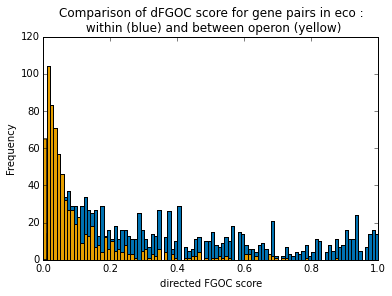

In [165]:
print "Analysing operons for %s organism ..."%(org)
imgDir = '/home/jaggu/research/projectFiles/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.Figure()
ax = fig.add_subplot(1,1,1)

w_vals = [wOp_dict.values()[i][0] for i in range(0,len(wOp_dict))]
bw_vals = [bwOp_dict.values()[i][0] for i in range(0,len(bwOp_dict))]

n_w,bins_w,patches_w = plt.hist(w_vals,bins=np.arange(0,1.01,0.01),color='#0072b2')
n_bw,bins_bw,patches_bw = plt.hist(bw_vals,bins=np.arange(0,1.01,0.01),color='#e69f00')
plt.xlabel('directed FGOC score')
plt.ylabel('Frequency')
plt.title('Comparison of dFGOC score for gene pairs in %s : \n within (blue) and between operon (yellow)'%(org))
#plt.show()

# Saving figure
fname = org+'_opAndbwOp_genePairs.hist.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)

Analysing operons for eco organism ...


/home/jaggu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


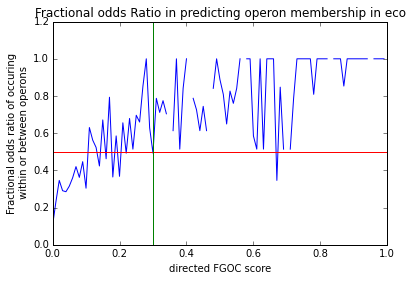

In [167]:
print "Analysing operons for %s organism ..."%(org)

prob_w = n_w/len(wOp_dict)
prob_bw = n_bw/len(bwOp_dict)

yVal = prob_w/(prob_w + prob_bw) #Fraction Odds ratio -> prob(within operon)/(prob(within)+prob(between))

xVal = np.arange(0,1.,0.01)
plt.plot(xVal,yVal,)
plt.axhline(y=0.5,color='r')
plt.axvline(x=0.3,color='g')
plt.ylim([0,1.2])
plt.title('Fractional odds Ratio in predicting operon membership in '+ org)
plt.xlabel('directed FGOC score')
plt.ylabel('Fractional odds ratio of occuring \n within or between operons')
#plt.show()

# Saving figure
fname = org+'_oddsRatio_opAndbwOp.linePlot.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)


# Normalizing the graphs by spanning operonic genes across all species
The motive is to try normalizing this odds ratio plot across all predicted operons. There are many sources for 
predicted operons. But the one downloadable file across all bacteria appears to be from [ODB3](http://operondb.jp/) ; Locus tag is used as an identifier. The statistics of this database reported is that ~ 2800 genomes are used in their prediction. The steps involved are - 
<ol>
<li> Make a huge list of all COG pairs that are classified to be in operons (from the conserved_operon.download.txt: done on 4th October 2015) </li>
<li> For every organism, there is a list of all COG pairs. Two different COG_list are made : (operon COGpair list) and (not Operon COGpair list); </li>
<li> Get FGOC score for each list (CogPair); org : [dirfgoc score list for Operon], [dirfgoc score list for non operon] </li>
<li> For the dirFgoc score list we make a histogram; Also normalize the histogram to the len of the COG list (operon or not operon respectively); The bin size is 0.1 from 0 to 1 </li>
<li> Then average this list across all organisms; The total number of organisms spanned is 2,658 </li></ol>

In [59]:
# Making a gigantic COG pair list that spreads across all species; from odb;
# Load dictionaries
import os

opDBdir = '/home/jaggu/research/downloads/operons_databases/odb3'
pklPath = '/home/jaggu/research/projectFiles/operons/pklFiles'
fname = 'conserved_operon.download.txt'

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def savePkl(db,pklFname):
    f = os.path.join(pklPath,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

allOp_COGpairs_list = list()

with open(os.path.join(opDBdir,fname)) as f:
    for line in f:
        if not line.startswith('coid'):
            allLTags = line.split('\t')[2]
            lTag_list = allLTags.split(',')
            lTagPairs = zip(lTag_list,lTag_list[1:])
            for lTagPair in lTagPairs:
                lTag1,lTag2 = lTagPair
                cogA,cogB = getCog(lTag1),getCog(lTag2)
                if not('nan' is cogA or 'nan' is cogB):
                    cogPair = (cogA,cogB)
                    if not cogPair in allOp_COGpairs_list: 
                        allOp_COGpairs_list.append(cogPair)

savePkl(allOp_COGpairs_list,'allOperon_COGpairs.list.pkl')
print "All operon COGpairs list Pickled"

All operon COGpairs list Pickled


In [ ]:
# Loading relevant dictionaries
import cPickle as pickle
import os

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

org_cogPair_dict = loadPkl('org_cogPair.dict.pkl')
allOp_COGpairs_list = loadPkl('allOperon_COGpairs.list.pkl')

In [154]:
# Iterating through all the organisms with its cogPairs and calculating the histogram of operon gene pairs and not 
# operon gene pairs; 
import numpy as np

org_normHist_dict = dict()

def getFgocScore(cogPair):
    fgocInfo = cogPair_fgocInfo_dict[cogPair]
    dirFgoc = fgocInfo[3]
    return dirFgoc

def getHistogramVals(allPairs):
    all_dFgoc_list = list()
    for cogPair in allPairs:
        dirFgoc = np.float(getFgocScore(cogPair))
        all_dFgoc_list.append(dirFgoc)
    valHist_dfgoc,binnings = np.histogram(all_dFgoc_list,bins=np.arange(0,1.01,0.01))
    normHist_dfgoc = np.divide(valHist_dfgoc, len(allPairs),dtype=float)
    return normHist_dfgoc

for org, org_cogPairList in org_cogPair_dict.items():
    # Removing all instances of '-' as the COG pair
    org_cogPairList = [item for item in org_cogPairList if not (item[0] =='-' or item[1] =='-')]
    allOp_dfgoc = list()
    allnotOp_dfgoc = list()
    
    opPairs = list(set(org_cogPairList)&set(allOp_COGpairs_list))
    notOpPairs = list(set(org_cogPairList)-set(allOp_COGpairs_list))
    
    if len(opPairs)> 0: opNormHist_list = getHistogramVals(opPairs) #Plasmids get included and makes it nan
    if len(notOpPairs)>0: notOpNormHist_list = getHistogramVals(notOpPairs)
    org_normHist_dict[org] = (opNormHist_list,notOpNormHist_list)

allOp_hist = list()
allNotOp_hist = list()
for i, (opArray,notOpArray) in enumerate(org_normHist_dict.values()):
    allOp_hist.append(opArray)
    allNotOp_hist.append(notOpArray)

norm_op = np.mean(allOp_hist,axis=0)
norm_notOp = np.mean(allNotOp_hist,axis=0)

print "Normalized histogram values of Operon dirFGOC and not Operon dirFGOC gene pairs calculated for all species"
print "Number of organisms considered : %d "%(len(allOp_hist))

Normalized histogram values of Operon dirFGOC and not Operon dirFGOC gene pairs calculated for all species
Number of organisms considered : 2658 


/home/jaggu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


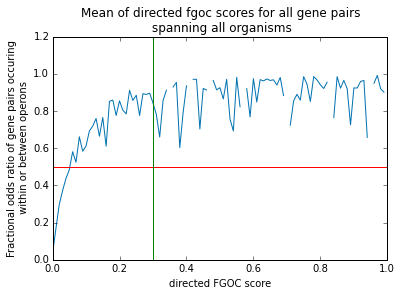

In [168]:
# Plotting the fractional odds ratio of gene pairs within and between operons

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


yVal = norm_op/(norm_op + norm_notOp) #Fraction Odds ratio -> prob(within operon)/(prob(within)+prob(between))
xVal = np.arange(0,1.,0.01)

plt.plot(xVal,yVal,color='#0072b2')
plt.axhline(y=0.5,color='r')
plt.axvline(x=0.3,color='g')
plt.ylim([0,1.2])
plt.title('Mean of directed fgoc scores for all gene pairs \n spanning all organisms')
plt.xlabel('directed FGOC score')
plt.ylabel('Fractional odds ratio of gene pairs occuring \n within or between operons')

#plt.show()

# Saving figure
fname = 'allOrgs_oddsRatio_opAndbwOp.linePlot.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)
